In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.3'

# Understanding recurrent neural networks

This notebook contains the code samples found in Chapter 6, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

---

[...]

## A first recurrent layer in Keras

The process we just naively implemented in Numpy corresponds to an actual Keras layer: the `SimpleRNN` layer:


In [2]:
from keras.layers import SimpleRNN

There is just one minor difference: `SimpleRNN` processes batches of sequences, like all other Keras layers, not just a single sequence like 
in our Numpy example. This means that it takes inputs of shape `(batch_size, timesteps, input_features)`, rather than `(timesteps, 
input_features)`.

Like all recurrent layers in Keras, `SimpleRNN` can be run in two different modes: it can return either the full sequences of successive 
outputs for each timestep (a 3D tensor of shape `(batch_size, timesteps, output_features)`), or it can return only the last output for each 
input sequence (a 2D tensor of shape `(batch_size, output_features)`). These two modes are controlled by the `return_sequences` constructor 
argument. Let's take a look at an example:

In [10]:
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN

model = Sequential()
'''
词嵌入的维度为32维，总共有10000个词，所以需要预留32*10000个位置来盛装这些值，所需需要
接受的但数量为32*10000
'''
model.add(Embedding(10000, 32))
'''
SimpleRNN 32 : 指的是需要32个神经元。
为什么参数个数是2080呢？
第一层SimpleRNN的神经元个数为32个，从而(32+1)*32，这个是正常神经元所需要计算的参数；
而对于RNN而言，为了利用前面隐藏层(神经元)遗留的信息(这里特殊，是初始词向量矩阵)，
所以为了得到相应的矩阵，需要用32*32存储
从而所需要的参数为：(32+1)*32+32*32
'''
model.add(SimpleRNN(32))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 32)                2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


SimpleRNN的参数计算理解：
<img src="./images/SimpleRNN参数计算.png"/>

In [4]:
model = Sequential()

model.add(Embedding(10000, 32))
'''
return_sequences的作用，若SimpleRNN是最后一层，则return_sequences=False,就会输出
32*1的结果；而若是如果不希望输出，而是将SimpleRNN作为下一层的输入时，那么久将
return_sequences=True,这个就会返回一个相应的序列。
'''
model.add(SimpleRNN(32, return_sequences=True))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
Total params: 322,080
Trainable params: 322,080
Non-trainable params: 0
_________________________________________________________________


It is sometimes useful to stack several recurrent layers one after the other in order to increase the representational power of a network. 
In such a setup, you have to get all intermediate layers to return full sequences:

In [5]:
model = Sequential()
model.add(Embedding(10000, 32))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32, return_sequences=True))
model.add(SimpleRNN(32))  # This last layer only returns the last outputs.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                2080      
Total params: 328,320
Trainable params: 328,320
Non-trainable params: 0
_________________________________________________________________


Now let's try to use such a model on the IMDB movie review classification problem. First, let's preprocess the data:

In [6]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)
batch_size = 32

print('Loading data...')
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), 'train sequences')
print(len(input_test), 'test sequences')

print('Pad sequences (samples x time)')
# 转为矩阵
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print('input_train shape:', input_train.shape)
print('input_test shape:', input_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
input_train shape: (25000, 500)
input_test shape: (25000, 500)


Let's train a simple recurrent network using an `Embedding` layer and a `SimpleRNN` layer:

In [7]:
from keras.layers import Dense

model = Sequential()
model.add(Embedding(max_features, 32))
model.add(SimpleRNN(32))
model.add(Dense(1, activation='sigmoid'))
# rmsprop 不像adam有动量，比较适合rnn训练
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 12s 585us/step - loss: 0.6474 - acc: 0.6087 - val_loss: 0.4873 - val_acc: 0.7892
Epoch 2/10
20000/20000 [==============================] - 11s 536us/step - loss: 0.4137 - acc: 0.8216 - val_loss: 0.5418 - val_acc: 0.7440
Epoch 3/10
20000/20000 [==============================] - 11s 533us/step - loss: 0.2869 - acc: 0.8876 - val_loss: 0.3457 - val_acc: 0.8544
Epoch 4/10
20000/20000 [==============================] - 11s 539us/step - loss: 0.2217 - acc: 0.9139 - val_loss: 0.3442 - val_acc: 0.8544
Epoch 5/10
20000/20000 [==============================] - 11s 535us/step - loss: 0.1653 - acc: 0.9390 - val_loss: 0.3785 - val_acc: 0.8684
Epoch 6/10
20000/20000 [==============================] - 11s 538us/step - loss: 0.1126 - acc: 0.9607 - val_loss: 0.4122 - val_acc: 0.8432
Epoch 7/10
20000/200

Let's display the training and validation loss and accuracy:

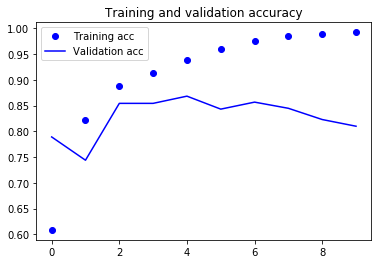

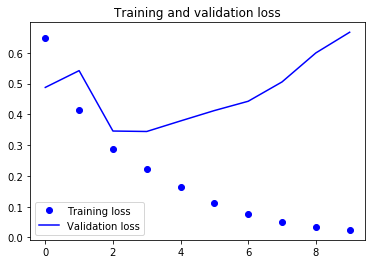

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As a reminder, in chapter 3, our very first naive approach to this very dataset got us to 88% test accuracy. Unfortunately, our small 
recurrent network doesn't perform very well at all compared to this baseline (only up to 85% validation accuracy). Part of the problem is 
that our inputs only consider the first 500 words rather the full sequences -- 
hence our RNN has access to less information than our earlier baseline model. The remainder of the problem is simply that `SimpleRNN` isn't very good at processing long sequences, like text. Other types of recurrent layers perform much better. Let's take a look at some 
more advanced layers.

[...]

## A concrete LSTM example in Keras

Now let's switch to more practical concerns: we will set up a model using a LSTM layer and train it on the IMDB data. Here's the network, 
similar to the one with `SimpleRNN` that we just presented. We only specify the output dimensionality of the LSTM layer, and leave every 
other argument (there are lots) to the Keras defaults. Keras has good defaults, and things will almost always "just work" without you 
having to spend time tuning parameters by hand.

In [11]:
from keras.layers import LSTM

model = Sequential()
# 词嵌入输入
model.add(Embedding(max_features, 32))
# 32 表示LSTM有32个神经元，这里的参数都调的比较好了，只需要调节神经元个数就行了
model.add(LSTM(32))
'''
调参的方法：
    1 超参数的调节；
    2 为什么LSTM的神经元选了32个；
    3 LSTM深度加深一点？
'''
# output层
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(input_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 48s 2ms/step - loss: 0.5847 - acc: 0.7298 - val_loss: 0.4371 - val_acc: 0.8280
Epoch 2/10
20000/20000 [==============================] - 50s 2ms/step - loss: 0.3377 - acc: 0.8659 - val_loss: 0.3605 - val_acc: 0.8494
Epoch 3/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.2530 - acc: 0.9032 - val_loss: 0.3315 - val_acc: 0.8568
Epoch 4/10
20000/20000 [==============================] - 50s 3ms/step - loss: 0.2157 - acc: 0.9207 - val_loss: 0.2888 - val_acc: 0.8852
Epoch 5/10
20000/20000 [==============================] - 49s 2ms/step - loss: 0.1916 - acc: 0.9281 - val_loss: 0.3567 - val_acc: 0.8814
Epoch 6/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.1678 - acc: 0.9401 - val_loss: 0.4111 - val_acc: 0.8560
Epoch 7/10
20000/20000 [==============================] - 51s 3ms/step - loss: 0.1549 - acc: 0.9421 - val_loss: 0.3258 - val_acc:

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


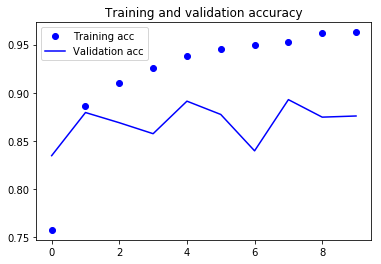

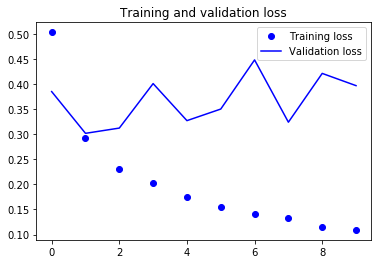

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()